# **DATA CLEANING SECTION**

In [1]:
!pip install kaggle

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Define the filename directly
FILENAME = "life expectancy.csv"

# Load the CSV file
df = pd.read_csv(FILENAME)

<h1 style="color:red;">
  🔴 DELETE NON-NECESSARY COLUMNS.<br>
</h1>

In [4]:
# Drop irrelevant or empty columns
# Year is the same for all countries
# Corruption column is empty
df = df.drop(columns=['Country Code', 'Year', 'Corruption'], errors='ignore')

<h1 style="color:red;">
  🔴 ROUND NUMERICAL VALUES TO 2 DECIMALS.<br>
</h1>

In [5]:
# Round all numeric columns to 2 decimals
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].round(2)

<h1 style="color:red;">
  🔴 AVOID DUPLICATES.<br>
</h1>

In [6]:
# Count duplicates per country
duplicates = df['Country Name'].value_counts()
print("Countries with duplicates:\n", duplicates[duplicates > 1])

Countries with duplicates:
 Country Name
Afghanistan             19
Angola                  19
Albania                 19
Andorra                 19
United Arab Emirates    19
                        ..
Vanuatu                 19
Samoa                   19
South Africa            19
Zambia                  19
Zimbabwe                19
Name: count, Length: 174, dtype: int64


In [7]:
# Keep one row per country
df = df.drop_duplicates(subset=['Country Name'], keep='first')

<h1 style="color:red;">
  🔴 DELETE NON-NECESSARY COLUMNS.<br>
</h1>

In [8]:
# Drop features that are redundant, ambiguous, or not useful for prediction

# Keeping too many correlated columns can cause multicollinearity,
# which reduces model interpretability and stability.

cols_to_drop = [
    'Unemployment',              # Can be misleading: high-income countries may have high unemployment but good health outcomes
    'Sanitation',                # Often strongly correlated with income or development indicators already in the dataset
    'Injuries',                  # Too narrow/specific compared to broader health indicators
    'Communicable',              # Ambiguous/aggregate measure that overlaps with more specific disease indicators
    'NonCommunicable',           # Same issue as above
    'CO2',                       # Emissions correlate with industrialization, but not directly with individual health outcomes
    'Education Expenditure %',   # Relative to GDP — can be misleading if GDP is very low or very high
    'Health Expenditure %'       # Same as above
]
df = df.drop(columns=cols_to_drop)

<h1 style="color:red;">
  🔴 FILL THE EMPTY GAPS IN THE DATASET.<br>
</h1>

In [9]:
# Count how many missing values are in each column
missing_counts = df.isna().sum()

# Calculate the percentage of missing values per column
missing_percentages = (missing_counts / len(df)) * 100

# Round the percentages to 2 decimal places
missing_percentages = missing_percentages.round(2)

# Keep only the columns where there are missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Sort the results so that the columns with the most missing data come first
missing_percentages = missing_percentages.sort_values(ascending=False)

# Print the final result
print(missing_percentages)

Prevelance of Undernourishment    20.69
Life Expectancy World Bank         5.75
dtype: float64


In [10]:
undernour_corr = df[['Prevelance of Undernourishment', 'Life Expectancy World Bank']].dropna().corr().iloc[0, 1]
print(f"Correlation between Prevalence of Undernourishment and Life Expectancy: {undernour_corr:.3f}")

Correlation between Prevalence of Undernourishment and Life Expectancy: -0.722


In [11]:
# Define a function to fill missing values in a column
# using the median of each Region
def fill_missing_within_region(df, column_name):
    df[column_name] = (
        df.groupby('Region')[column_name]
          .transform(lambda x: x.fillna(x.median()))
    )
    return df

In [12]:
# Fill for 'Prevelance of Undernourishment' and for 'Life Expectancy World Bank'
df = fill_missing_within_region(df, 'Prevelance of Undernourishment')
df = fill_missing_within_region(df, 'Life Expectancy World Bank')

In [43]:
# Check for any remaining missing values in the entire DataFrame
missing_summary = df.isnull().sum()

# Print only columns with missing values (if any)
missing_summary = missing_summary[missing_summary > 0]

if missing_summary.empty:
    print("No missing values remain in the dataset.")
else:
    print("There are still missing values in the following columns:")
    print(missing_summary)

No missing values remain in the dataset.


In [14]:
print("Final dataset shape:", df.shape)
print("Remaining columns:", df.columns.tolist())

Final dataset shape: (174, 5)
Remaining columns: ['Country Name', 'Region', 'IncomeGroup', 'Life Expectancy World Bank', 'Prevelance of Undernourishment']


In [44]:
# Save the cleaned DataFrame to CSV
df.to_csv("cleaned_life_expectancy.csv", index=False)

# Download the file
# from google.colab import files
# files.download("cleaned_life_expectancy.csv")

# **STATISTICS**

In [16]:
df = pd.read_csv("cleaned_life_expectancy.csv")

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [18]:
import matplotlib.pyplot as plt

In [19]:
# Define X and y - removing 'Country Name' completely
X = df.drop(['Country Name', 'Life Expectancy World Bank'], axis=1) # Features
y = df['Life Expectancy World Bank'] # Target value

In [20]:
# One-hot encode categoricals and make sure all data is numeric
# The “missing” high income group (drop_first=True) is just the reference group from one-hot encoding
# The other coefficients show how much better or worse each category compares to that basel
X_encoded = pd.get_dummies(X, columns=['Region', 'IncomeGroup'], drop_first=True)

# Print chosen baselines
print("Baseline Region: East Asia & Pacific")
print("Baseline IncomeGroup: High income")

# Convert to NumPy floats
X_np = X_encoded.to_numpy(dtype=float)
y_np = y.to_numpy(dtype=float)

Baseline Region: East Asia & Pacific
Baseline IncomeGroup: High income


In [21]:
# Add a column of 1s to X for the intercept term (β0)
X_np = np.c_[np.ones(X_np.shape[0]), X_np]  # shape: (rows, columns+1)

In [22]:
# Apply the Normal Equation: β = (XᵀX)⁻¹ Xᵀy
# Compute XᵀX
X_transpose = X_np.T # Xᵀ
XTX = X_transpose @ X_np # XᵀX

# Compute the inverse of XᵀX
XTX_inv = np.linalg.inv(XTX) # (XᵀX)⁻¹

# Compute Xᵀy
XTy = X_transpose @ y_np # Xᵀy

# Multiply (XᵀX)⁻¹ with Xᵀy to get β
beta = XTX_inv @ XTy # β = (XᵀX)⁻¹ Xᵀy

In [23]:
# Predictions:  ŷ = X · β
y_pred = X_np @ beta

In [24]:
# Calculate R² manually
SS_total = np.sum((y_np - np.mean(y_np))**2) # where SS_tot = Σ(yᵢ - ȳ)²  (total variance)
SS_residual = np.sum((y_np - y_pred)**2) # SS_res = Σ(yᵢ - ŷᵢ)² (unexplained variance)
r2 = 1 - (SS_residual / SS_total) # R²: proportion of the variance in y explained by the model

In [25]:
# Show results
feature_names = ['Intercept'] + list(X_encoded.columns)
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Impact (β)': beta
}).sort_values('Impact (β)', ascending=False)

# R²: proportion of the variance in y explained by the model (in life expectancy across countries)
# Coefficients (β values): how much the target changes for a one-unit change in each feature while holding other features constant
print(f"R² Score (whole dataset): {r2:.3f}")
print("\nCoefficients:")
print(coefficients)

# Positive β values → Higher values of this feature increase predicted life expectancy
# Negative β values → Higher values decrease predicted life expectancy

R² Score (whole dataset): 0.852

Coefficients:
                              Feature  Impact (β)
0                           Intercept   76.558076
5                Region_North America    1.854487
3    Region_Latin America & Caribbean    1.390441
4   Region_Middle East & North Africa    0.952263
2        Region_Europe & Central Asia   -0.039317
1      Prevelance of Undernourishment   -0.155692
6                   Region_South Asia   -0.460134
10    IncomeGroup_Upper middle income   -4.933645
9     IncomeGroup_Lower middle income   -8.231782
8              IncomeGroup_Low income   -9.793143
7           Region_Sub-Saharan Africa  -11.809196


In [26]:
# Sort coefficients
coefficients_sorted = coefficients.sort_values('Impact (β)', ascending=True)

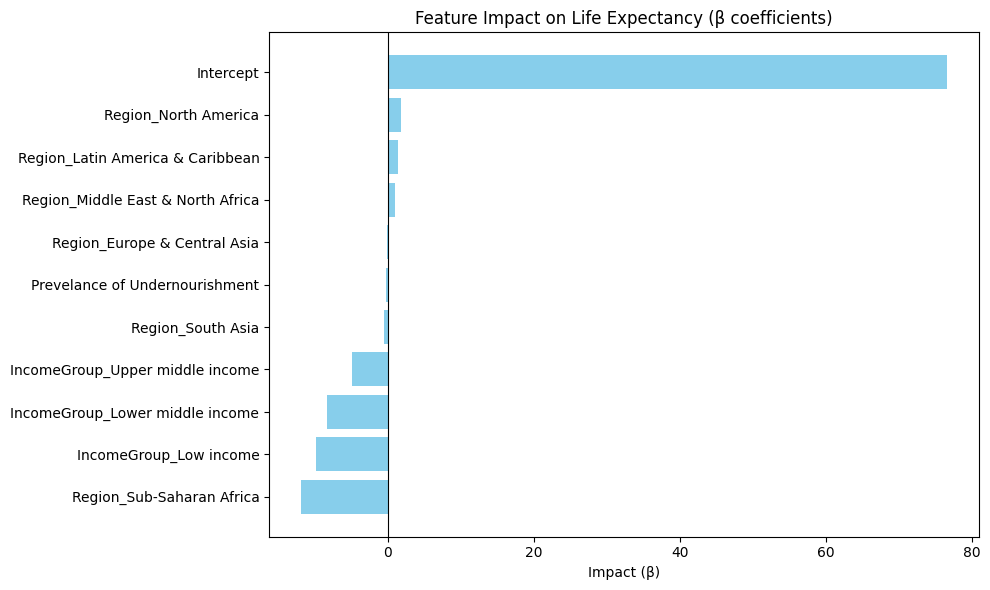

In [27]:
# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(coefficients_sorted['Feature'], coefficients_sorted['Impact (β)'], color='skyblue')

# Add a vertical line at 0 for reference
plt.axvline(0, color='black', linewidth=0.8)

plt.xlabel('Impact (β)')
plt.title('Feature Impact on Life Expectancy (β coefficients)')
plt.tight_layout()
plt.show()

# **MACHINE LEARNING PHASE**

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [29]:
# Train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [30]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [31]:
# Evaluate performance
print(f"Training R²: {model.score(X_train, y_train):.3f}")
print(f"Test R²: {model.score(X_test, y_test):.3f}")

Training R²: 0.851
Test R²: 0.844


In [32]:
# Show coefficients
coefficients = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Impact': model.coef_
}).sort_values('Impact', ascending=False)

In [33]:
print("\nTop Features Affecting Life Expectancy:")
print(coefficients)


Top Features Affecting Life Expectancy:
                             Feature     Impact
4               Region_North America   2.151959
2   Region_Latin America & Caribbean   1.906553
3  Region_Middle East & North Africa   1.687789
5                  Region_South Asia  -0.007491
1       Region_Europe & Central Asia  -0.069257
0     Prevelance of Undernourishment  -0.148346
9    IncomeGroup_Upper middle income  -4.691223
8    IncomeGroup_Lower middle income  -8.456007
7             IncomeGroup_Low income -10.734792
6          Region_Sub-Saharan Africa -11.551999


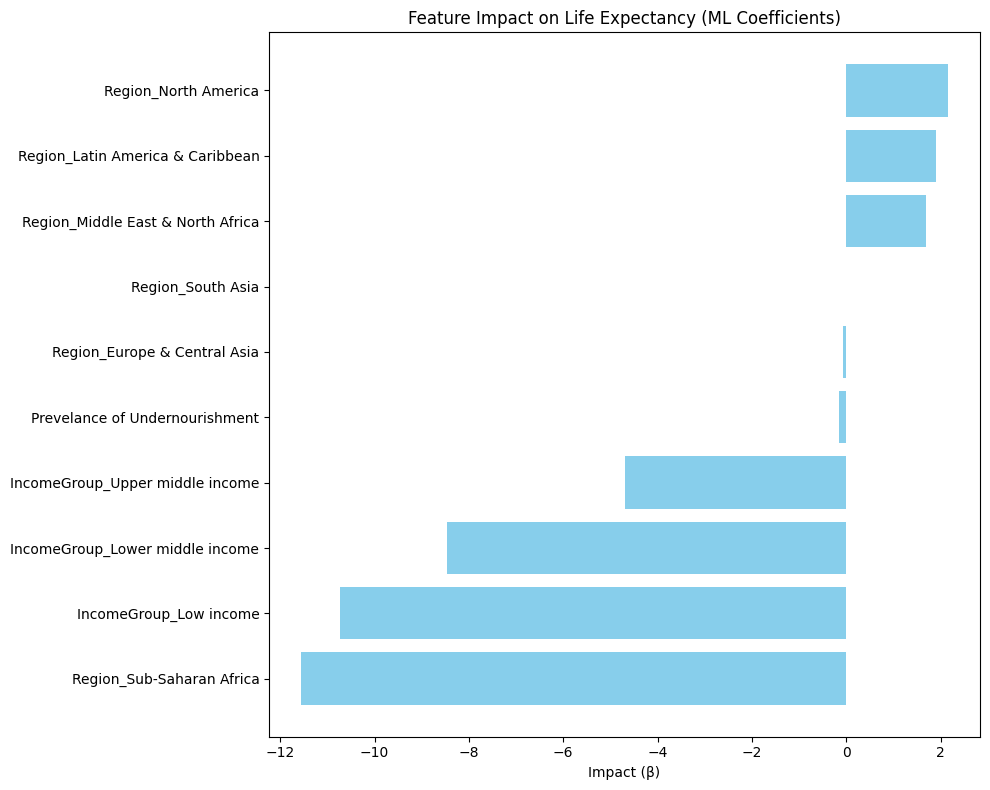

In [34]:
# Plot of the results by the impact
coefficients_sorted = coefficients.copy()
coefficients_sorted = coefficients_sorted.sort_values('Impact', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(coefficients_sorted['Feature'], coefficients_sorted['Impact'], color='skyblue')
plt.xlabel('Impact (β)')
plt.title('Feature Impact on Life Expectancy (ML Coefficients)')
plt.tight_layout()
plt.show()

# **REGULARIZATION WITH RIDGE AND LASSO REGRESSION**

In [35]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

In [36]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
# Ridge Regression (L2 Regularization)
# Formula: w_ridge = (X^T X + λ I)^(-1) X^T y
# λ = alpha (regularization strength)
# I = identity matrix
# Penalizes large coefficients, shrinks them toward zero but rarely exactly zero

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

Ridge()

In [38]:
print("\nRidge Regression:")
print(f" Training R²: {ridge.score(X_train_scaled, y_train):.3f}")
print(f" Test R²: {ridge.score(X_test_scaled, y_test):.3f}")


Ridge Regression:
 Training R²: 0.851
 Test R²: 0.844


In [39]:
coeff_ridge = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Impact': ridge.coef_
}).sort_values('Impact', ascending=False)
print("\nTop Features (Ridge):")
print(coeff_ridge)


Top Features (Ridge):
                             Feature    Impact
2   Region_Latin America & Caribbean  0.754677
3  Region_Middle East & North Africa  0.523625
4               Region_North America  0.196390
1       Region_Europe & Central Asia  0.033727
5                  Region_South Asia  0.009639
0     Prevelance of Undernourishment -1.912037
9    IncomeGroup_Upper middle income -2.011565
7             IncomeGroup_Low income -3.530949
8    IncomeGroup_Lower middle income -3.650490
6          Region_Sub-Saharan Africa -4.964325


In [40]:
# Lasso Regression (L1 Regularization)
# Formula: Loss = MSE + λ * sum(|w_j|)
# λ = alpha (regularization strength)
# Penalizes coefficients by absolute value
# Can shrink some coefficients exactly to zero (feature selection)

lasso = Lasso(alpha=0.1, max_iter=5000)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.1, max_iter=5000)

In [41]:
print("\nLasso Regression:")
print(f" Training R²: {lasso.score(X_train_scaled, y_train):.3f}")
print(f" Test R²: {lasso.score(X_test_scaled, y_test):.3f}")


Lasso Regression:
 Training R²: 0.850
 Test R²: 0.847


In [42]:
coeff_lasso = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Impact': lasso.coef_
}).sort_values('Impact', ascending=False)
print("\nTop Features (Lasso):")
print(coeff_lasso)


Top Features (Lasso):
                             Feature    Impact
2   Region_Latin America & Caribbean  0.581212
3  Region_Middle East & North Africa  0.401788
4               Region_North America  0.105911
1       Region_Europe & Central Asia  0.000000
5                  Region_South Asia -0.000000
9    IncomeGroup_Upper middle income -1.797922
0     Prevelance of Undernourishment -1.925194
7             IncomeGroup_Low income -3.340272
8    IncomeGroup_Lower middle income -3.460295
6          Region_Sub-Saharan Africa -5.081079
